# Data Analysis


In [24]:
# general_loader.py
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## loading data from drive

In [6]:
from google.colab import drive

drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/SemEval-2026/train/eng_laptop_train_alltasks.jsonl'

data = []
with open(dataset_path, 'r') as f:
    for line in f:
        data.append(json.loads(line))

print(f"Loaded {len(data)} sentence-level entries")
print("Sample entry:\n", data[0])


Mounted at /content/drive
Loaded 4076 sentence-level entries
Sample entry:
 {'ID': 'laptop_quad_dev_1', 'Text': 'this unit is ` ` pretty ` ` and stylish , so my high school daughter was attracted to it for that reason .', 'Quadruplet': [{'Aspect': 'unit', 'Category': 'LAPTOP#DESIGN_FEATURES', 'Opinion': 'pretty', 'VA': '7.12#7.12'}, {'Aspect': 'unit', 'Category': 'LAPTOP#DESIGN_FEATURES', 'Opinion': 'stylish', 'VA': '7.12#7.12'}]}


## Flattening dataset into quadruples

In [8]:
def load_general_dataset(path):
    """
    Load SemEval dataset in general format (one row per quadruplet).

    Returns: DataFrame with columns:
    ID, Text, Aspect, Category, Opinion, VA, V, A
    """
    data = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            data.append(json.loads(line))

    records = []
    for row in data:
        for quad in row["Quadruplet"]:
            V, A = map(float, quad["VA"].split("#"))
            records.append({
                "ID": row["ID"],
                "Text": row["Text"],
                "Aspect": quad["Aspect"],
                "Category": quad["Category"],
                "Opinion": quad["Opinion"],
                "V": V,
                "A": A
            })

    return pd.DataFrame(records)

In [19]:
df = load_general_dataset(dataset_path)
df.head()

,ID,Text,Aspect,Category,Opinion,V,A
0,laptop_quad_dev_1,"this unit is ` ` pretty ` ` and stylish , so m...",unit,LAPTOP#DESIGN_FEATURES,pretty,7.12,7.12
1,laptop_quad_dev_1,"this unit is ` ` pretty ` ` and stylish , so m...",unit,LAPTOP#DESIGN_FEATURES,stylish,7.12,7.12
2,laptop_quad_dev_2,for now i ' m okay with upping the experience ...,device,LAPTOP#GENERAL,NULL,5.50,5.25
3,laptop_quad_dev_3,"seems unlikely but whatever , i ' ll go with it .",NULL,LAPTOP#GENERAL,NULL,5.00,5.12
4,laptop_quad_dev_4,this version has been my least favorite versio...,version,LAPTOP#GENERAL,least favorite,3.30,6.60


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5773 entries, 0 to 5772
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        5773 non-null   object 
 1   Text      5773 non-null   object 
 2   Aspect    5773 non-null   object 
 3   Category  5773 non-null   object 
 4   Opinion   5773 non-null   object 
 5   V         5773 non-null   float64
 6   A         5773 non-null   float64
dtypes: float64(2), object(5)
memory usage: 315.8+ KB


In [20]:
print("Sentence-level entries:", len(data))
print("Quadruplet-level entries:", len(df))


Sentence-level entries: 4076
Quadruplet-level entries: 5773


In [11]:
print("Number of columns:", len(df.columns))
print("Columns:", df.columns.tolist())


Number of columns: 7
Columns: ['ID', 'Text', 'Aspect', 'Category', 'Opinion', 'V', 'A']


In [12]:
print("Unique Categories:", df["Category"].nunique())
print("Unique Aspects:", df["Aspect"].nunique())
print("Unique Opinions:", df["Opinion"].nunique())


Unique Categories: 121
Unique Aspects: 956
Unique Opinions: 1156


In [13]:
category_counts = df["Category"].value_counts()
category_ratio = category_counts / category_counts.sum()

print("Category counts:\n", category_counts)
print("\nCategory ratio:\n", category_ratio)


Category counts:
 Category
LAPTOP#GENERAL                    1200
LAPTOP#OPERATION_PERFORMANCE       632
LAPTOP#DESIGN_FEATURES             489
LAPTOP#PRICE                       208
LAPTOP#QUALITY                     201
                                  ... 
MULTIMEDIA_DEVICES#PRICE             1
OPTICAL_DRIVES#DESIGN_FEATURES       1
CPU#DESIGN_FEATURES                  1
SUPPORT#DESIGN_FEATURES              1
Out_Of_Scope#USABILITY               1
Name: count, Length: 121, dtype: int64

Category ratio:
 Category
LAPTOP#GENERAL                    0.207864
LAPTOP#OPERATION_PERFORMANCE      0.109475
LAPTOP#DESIGN_FEATURES            0.084705
LAPTOP#PRICE                      0.036030
LAPTOP#QUALITY                    0.034817
                                    ...   
MULTIMEDIA_DEVICES#PRICE          0.000173
OPTICAL_DRIVES#DESIGN_FEATURES    0.000173
CPU#DESIGN_FEATURES               0.000173
SUPPORT#DESIGN_FEATURES           0.000173
Out_Of_Scope#USABILITY            0.000173
Name:

## Analysis on Valence Arousal scores

In [14]:
print("Valence stats:\n", df["V"].describe())
print("Arousal stats:\n", df["A"].describe())



Valence stats:
 count    5773.000000
mean        5.936842
std         1.763164
min         1.000000
25%         4.380000
50%         6.620000
75%         7.380000
max         8.830000
Name: V, dtype: float64
Arousal stats:
 count    5773.00000
mean        6.66797
std         1.03192
min         3.83000
25%         5.83000
50%         6.88000
75%         7.50000
max         8.83000
Name: A, dtype: float64


In [15]:
quads_per_sentence = df.groupby("ID").size()
print("Mean quadruplets per sentence:", quads_per_sentence.mean())
print("Max quadruplets in a sentence:", quads_per_sentence.max())


Mean quadruplets per sentence: 1.4163395485770363
Max quadruplets in a sentence: 10


## Data Integrity check

In [16]:
# some aspects and opinions aren't in the sentence therefore considered implicit and a string "NULL"
# These don't indicate annotation error but rather coresspond to implicit aspects/opinions

null_aspects = (df["Aspect"] == "NULL").sum()
null_opinions = (df["Opinion"] == "NULL").sum()

print("Implicit Aspects (string 'NULL'):", null_aspects)
print("Implicit Opinions (string 'NULL'):", null_opinions)

print(f"{null_aspects/len(df)*100:.2f}% aspects are implicit")
print(f"{null_opinions/len(df)*100:.2f}% opinions are implicit")



Implicit Aspects (string 'NULL'): 1254
Implicit Opinions (string 'NULL'): 1583
21.72% aspects are implicit
27.42% opinions are implicit


In [17]:
positive = (df["V"] > 5).sum()
negative = (df["V"] < 5).sum()
neutral  = (df["V"] == 5).sum()

print("Positive samples:", positive)
print("Negative samples:", negative)
print("Neutral samples:", neutral)


Positive samples: 3788
Negative samples: 1799
Neutral samples: 186


## Distribution for Valence-Arousal

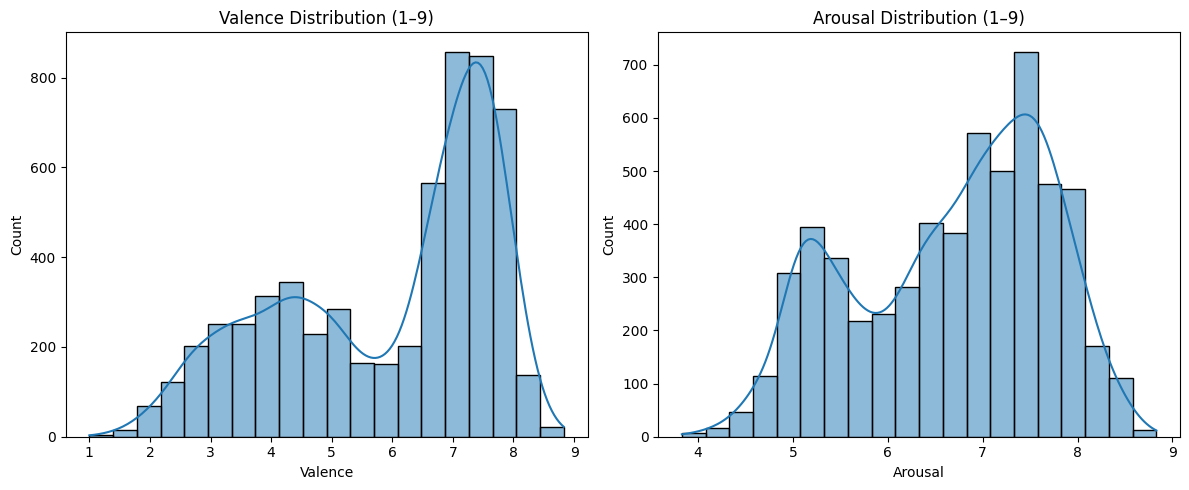

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df["V"], bins=20, kde=True, ax=axes[0])
axes[0].set_title("Valence Distribution (1–9)")
axes[0].set_xlabel("Valence")

sns.histplot(df["A"], bins=20, kde=True, ax=axes[1])
axes[1].set_title("Arousal Distribution (1–9)")
axes[1].set_xlabel("Arousal")

plt.tight_layout()
plt.show()

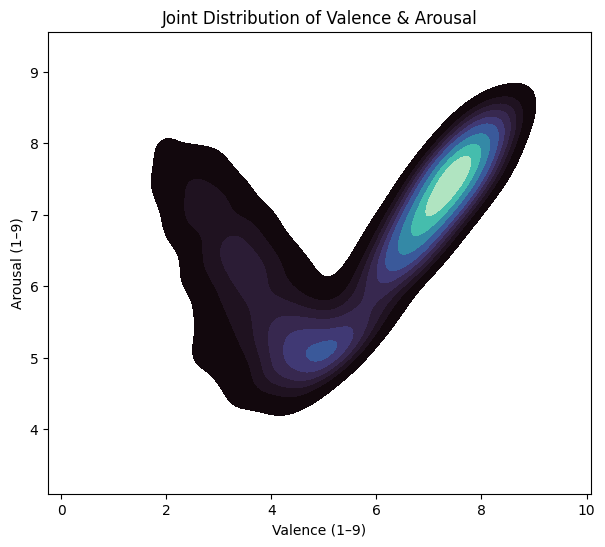

In [28]:
plt.figure(figsize=(7, 6))
sns.kdeplot(x=df["V"], y=df["A"], fill=True, cmap="mako", thresh=0.05)
plt.title("Joint Distribution of Valence & Arousal")
plt.xlabel("Valence (1–9)")
plt.ylabel("Arousal (1–9)")
plt.show()


In [30]:
corr = df["V"].corr(df["A"], method="pearson")
print(f"Pearson correlation between Valence & Arousal: {corr:.3f}")



Pearson correlation between Valence & Arousal: 0.598


In [32]:
extremes_valence = df[(df["V"] <= 2) | (df["V"] >= 8)]
extremes_arousal = df[(df["A"] <= 2) | (df["A"] >= 8)]

print(f"Extreme Valence samples: {len(extremes_valence)} / {len(df)}")
print(f"Extreme Arousal samples: {len(extremes_arousal)} / {len(df)}")


Extreme Valence samples: 419 / 5773
Extreme Arousal samples: 521 / 5773


Valence Bin Counts:
 ValenceBin
High      3364
Medium    1928
Low        481
Name: count, dtype: int64
Arousal Bin Counts:
 ArousalBin
High      4101
Medium    1672
Low          0
Name: count, dtype: int64


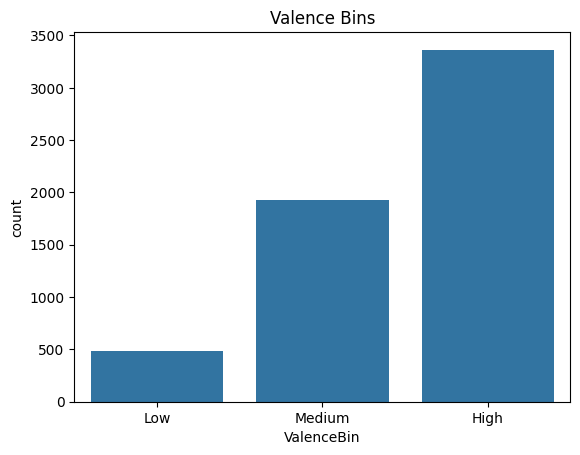

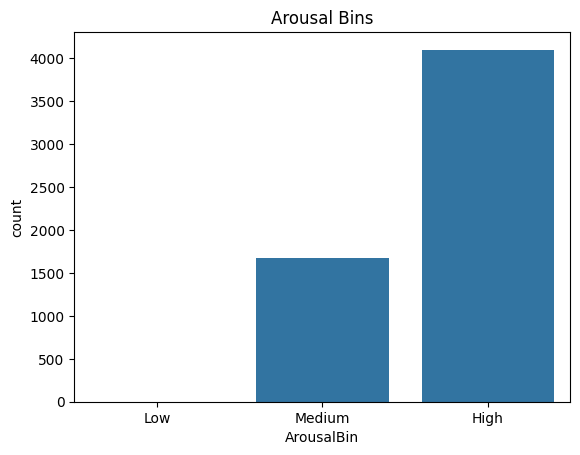

In [34]:
bins = [1, 3, 6, 9]  # example: low (1–3), medium (4–6), high (7–9)
labels = ["Low", "Medium", "High"]

df["ValenceBin"] = pd.cut(df["V"], bins=bins, labels=labels, include_lowest=True)
df["ArousalBin"] = pd.cut(df["A"], bins=bins, labels=labels, include_lowest=True)

print("Valence Bin Counts:\n", df["ValenceBin"].value_counts())
print("Arousal Bin Counts:\n", df["ArousalBin"].value_counts())

sns.countplot(x="ValenceBin", data=df)
plt.title("Valence Bins")
plt.show()

sns.countplot(x="ArousalBin", data=df)
plt.title("Arousal Bins")
plt.show()
